<a href="https://colab.research.google.com/github/hyeonmyeongpark/Mini-Project-4/blob/main/custom_tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import os
import matplotlib.pyplot as plt

In [ ]:
#구글드라이브에 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#특정 경로에 로드한 모델 돌리기
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [ ]:
#모델탑제
loaded_full_model = load_model("/content/drive/MyDrive/deep_learning_data/PIZA_mini Deeplearning/code/model/1-all-images-Adam.h5") 

Loading saved model from: /content/drive/MyDrive/deep_learning_data/PIZA_mini Deeplearning/code/model/1-all-images-Adam.h5


In [ ]:
# 이미지 정리 
IMG_SIZE = 480

# 이미지파일 경로를 tensor 타입으로 변경하기
def process_image(image_path):
  """
  Takes an image file path and turns it into a Tensor.
  """
  # Read in image file
  image = tf.io.read_file(image_path) # io : read_file 을 불러오기 위한것, 뭔지는 오빠도 자세히 모름
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3) #channels=3☜색이미지를 뜻한
  # Convert the colour channel values from 0-225 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired size (224, 244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

In [ ]:
BATCH_SIZE = 32

def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  # If the data if a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels
    
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [ ]:
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

In [ ]:
labels_csv = pd.read_csv("/content/drive/MyDrive/deep_learning_data/PIZA_mini Deeplearning/Data/labels.csv")
labels = labels_csv["breed"].to_numpy()
unique_breeds = np.unique(labels)

In [ ]:
custom_path = "/content/drive/MyDrive/deep_learning_data/PIZA_mini Deeplearning/Data/custom/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [ ]:
custom_data = create_data_batches(custom_image_paths, test_data = True)

Creating test data batches...


In [ ]:
custom_preds = loaded_full_model.predict(custom_data)

1/1 [==============================] - 13s 13s/step


In [ ]:
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['scotch_terrier',
 'afghan_hound',
 'doberman',
 'pomeranian',
 'toy_poodle',
 'toy_poodle',
 'miniature_poodle']

In [ ]:
# Get custom images (our unbatchify() function won't work since there aren't labels) 사용자 지정 이미지 가져오기(라벨이 없기 때문에 일괄 처리 해제() 기능이 작동하지 않는다)
custom_images = []
# Loop through unbatched data #배치되지 않는 
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

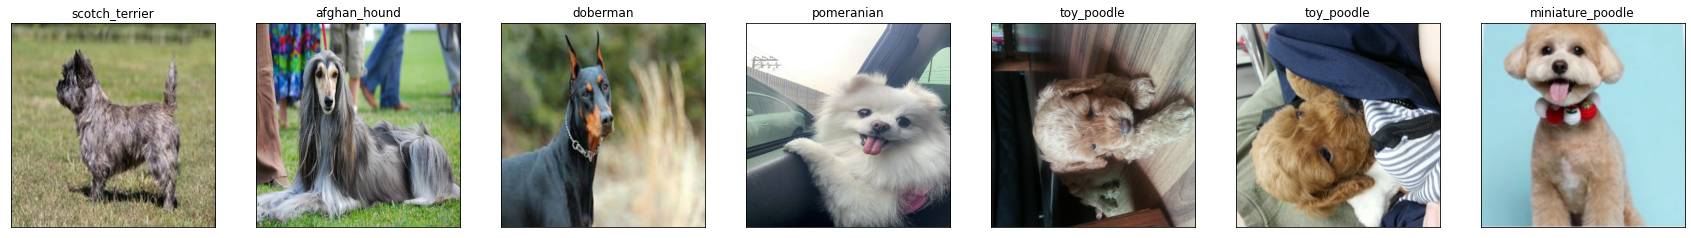

In [ ]:
# Check custom image predictions
plt.figure(figsize=(30, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, len(os.listdir(custom_path)), i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)